## Import library

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams

import os,random, time,datetime, cv2, albumentations, math, joblib, gc, math
from PIL import Image
from glob import glob

from tqdm import tqdm, trange
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data.sampler import RandomSampler
import torch.nn.functional as F


from torch.backends import cudnn

from efficientnet_pytorch import EfficientNet

import apex
from apex import amp, optimizers

from typing import Dict, Tuple, Any
from warmup_scheduler import GradualWarmupScheduler

%matplotlib inline
plt.rc('font', family='Malgun Gothic')

In [2]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]


## Set Params

In [3]:
class config:
    train_img_path = "../input/data/train/"
    test_img_path = "../input/data/test/"
    
    model_dir = "./model"
    log_dir = "./log"
    kernel_type = "efficient_baseline_pre2_rs512_b2"
    
    original_width = 120
    original_height = 120
    
#     resize_width = 128
#     resize_height = 128
    
    # Set Model-related params
    seed = 1993
    num_workers = 0
    num_folds = 5
    
    batch_size = 80
    init_lr =  1e-3
    num_epochs = 40
    start_from_epoch = 1
    stop_at_epoch = 999
    
    use_amp = True
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(config.seed)

## Load Datasets

In [4]:
def load_dataset(config, make_table = True):
    if make_table:
        train_img_ls = [ fn for fn in glob(config.train_img_path +'*.npy') ]
        test_img_ls = [ fn for fn in glob(config.test_img_path +'*.npy') ]

        trn_img_array = [ ]
        trn_label_array = [ ]
        ts_img_array = [ ]

        for img_fn in tqdm_notebook(train_img_ls):
            all_images = np.load( img_fn )
            img_array = np.hstack( all_images[:, : , :4].reshape( -1, 120 * 120 ) )
            label_array = all_images[:,:,4].reshape( -1, 120 * 120 )
            trn_img_array.append(img_array)
            trn_label_array.append( label_array )

        for img_fn in tqdm_notebook(test_img_ls):
            img_array = np.hstack( np.load( img_fn ).reshape( -1, 120 * 120 ) )
            ts_img_array.append(img_array)

        trn_img_array = np.vstack(trn_img_array)
        trn_label_array = np.vstack(trn_label_array)
        ts_img_array = np.vstack(ts_img_array)

        df_train = pd.DataFrame(trn_img_array)
        df_train_label = pd.DataFrame(trn_label_array)
        df_test = pd.DataFrame(ts_img_array)
        
        df_train.to_pickle("df_train.pkl")
        df_train_label.to_pickle("df_train_label.pkl")
        df_test.to_pickle("df_test.pkl")
    else:
        df_train = pd.read_pickle("df_train.pkl")
        df_train_label = pd.read_pickle("df_train_label.pkl")
        df_test = pd.read_pickle("df_test.pkl")
    
    return df_train, df_train_label, df_test

df_train, df_train_label, df_test = load_dataset(config, make_table=False)

In [5]:
print(f"... Size ... ")
print(f"Train-set \t\t: {df_train.shape}")
print(f"Train-label \t: {df_train_label.shape}")
print(f"Test-set \t\t: {df_test.shape}")

... Size ... 
Train-set 		: (62735, 57600)
Train-label 	: (62735, 14400)
Test-set 		: (2674, 57600)


In [6]:
# # Shuffle index
# df_train = df_train.sample(frac=1)
# df_train_label = df_train_label.iloc[ df_train.index ]

# df_train = df_train.reset_index(drop=True)
# df_train_label = df_train_label.reset_index(drop=True)

In [7]:
# # Split Folds based on how much rained 
# df_train_label_rowsum = pd.qcut( df_train_label.sum(axis=1) , q= 5, labels =False )

# kfolds = StratifiedKFold(n_splits= config.num_folds, random_state=config.seed, shuffle=True)
# for fold_ind, (trn_idx, val_idx) in tqdm( enumerate( kfolds.split(X = df_train, y = df_train_label_rowsum ) ) ):
#     df_train.loc[ val_idx, 'fold_ind' ] = fold_ind
    
# df_train["fold_ind"] = df_train["fold_ind"].astype(np.int8)

In [8]:
kfolds = KFold(n_splits= config.num_folds, random_state=config.seed, shuffle=True)
for fold_ind, (trn_idx, val_idx) in tqdm( enumerate( kfolds.split(X = df_train ) ) ):
    df_train.loc[ val_idx, 'fold_ind' ] = fold_ind
    
df_train["fold_ind"] = df_train["fold_ind"].astype(np.int8)

5it [00:00, 237.89it/s]


In [9]:
display( df_train.head(3) )
display( df_train_label.head(3) )
display( df_test.head(3) )

,0,1,2,3,4,5,6,7,8,9,...,57591,57592,57593,57594,57595,57596,57597,57598,57599,fold_ind
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,0,1,2,3,4,5,6,7,8,9,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def load_all_image(img_path):
    imgs= [ ]
    img_fns = sorted( glob( img_path +'/*.jpg' ) )
    for img_fn in tqdm(img_fns):        
        img = cv2.imread(img_fn)
        imgs.append( img )
    return imgs

In [15]:
df_train.shape

(62735, 57601)

In [16]:
train_images = df_train.drop('fold_ind',1).values.squeeze()
train_images = train_images.reshape( -1, config.original_width, config.original_height, 4 ).astype(np.float32)
train_images = np.transpose(train_images, (0,3,1,2))

In [27]:
train_label = df_train_label.values.squeeze()
train_label = train_label.reshape( -1, config.original_width, config.original_height, 1 ).astype(np.float32)
train_label = np.transpose(train_label, (0,3,1,2))

In [31]:
train_images.shape, train_label.shape

((62735, 4, 120, 120), (62735, 1, 120, 120))

In [38]:
class DaconRainDataset(Dataset):
    def __init__(self, config, imgs, label, indicies , mode):
        self.config = config
        self.imgs = imgs
        self.label = label
        self.indicies = np.asarray( indicies )
        self.mode = mode
        
    def __len__(self):
        return len( self.indicies )
    
    def __getitem__(self, idx):        
        idx = self.indicies[idx]
        
        # Load Image
        imgs = self.imgs[idx, :, :, :]
        imgs = imgs.astype(np.float32)
#         img = cv2.resize( img, ( self.config.resize_width, self.config.resize_height ) )
    
#         Scaling
        imgs = np.log1p(imgs)    
        
        # Label
        if self.mode == "train":            
            label = self.label[idx, :, :, :]
            label = label.astype(np.float32)
            return imgs, label
        else:
            return img

In [39]:
dataset_show = DaconRainDataset( config, train_images, train_label,  range(len(train_label)), mode="train"  )

## Visualize

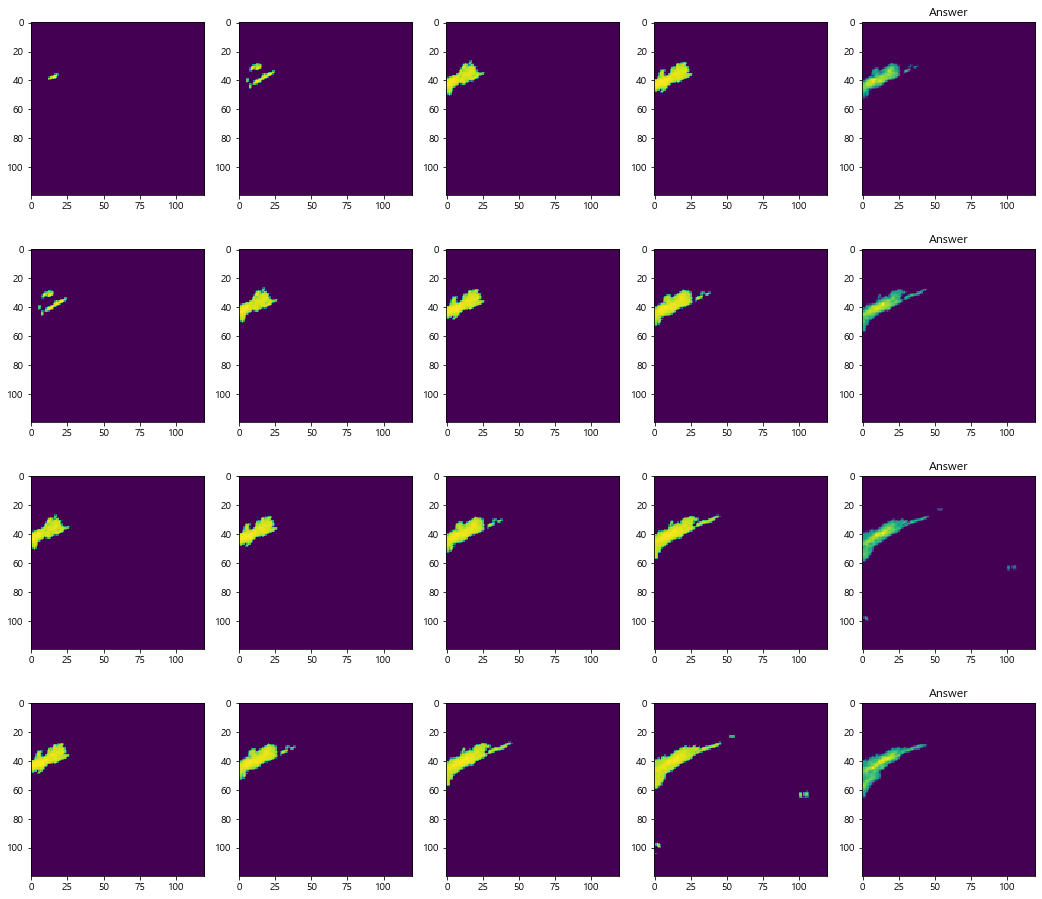

In [40]:
n_samples = 4
fig, axes = plt.subplots( n_samples , 5, figsize=(18,  n_samples* n_samples))

# random_indices = np.random.choice( range( 10000 ), n_samples, replace=False )
random_indices = range(4)

for row_ind in range(n_samples):
    data = dataset_show.__getitem__(random_indices[row_ind])
    imgs,  label  = data[0],  data[1]
    for col_ind in range(4):
        axes[row_ind][col_ind].imshow(  imgs[col_ind, :, :]  )
#         axes[row_ind][col_ind].set_title(f"Time Sequence : {random_axes[col_ind]}")
    axes[row_ind][4].imshow(label[0, : , :] )
    axes[row_ind][4].set_title("Answer")

In [41]:
class RainNet(nn.Module):
    def __init__(self, config):
        super(RainNet, self).__init__()
        self.config = config
        
        # Step 1
        self.conv1f = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=(3,3), padding=(5,5),  ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            
        )
        self.conv1s = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=(1,1) ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d( kernel_size=(2,2), stride=(2,2) )

        # Step 2
        self.conv2f = nn.Sequential(
            nn.Conv2d( in_channels = 64, out_channels=128, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv2s = nn.Sequential(
            nn.Conv2d( in_channels = 128, out_channels=128, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d( kernel_size=(2,2) , stride=(2,2) )
        
        # Step 3
        self.conv3f = nn.Sequential(
            nn.Conv2d( in_channels = 128, out_channels=256, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3s = nn.Sequential(
            nn.Conv2d( in_channels = 256, out_channels=256, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d( kernel_size=(2,2) , stride=(2,2) )
        
        # Step 4
        self.conv4f = nn.Sequential(
            nn.Conv2d( in_channels = 256, out_channels=512, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv4s = nn.Sequential(
            nn.Conv2d( in_channels = 512, out_channels=512, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.Sequential(
            nn.Dropout(0.5),
            nn.MaxPool2d( kernel_size=(2,2) , stride=(2,2) )
        )
        
        # Step 5
        self.conv5f = nn.Sequential(
            nn.Conv2d( in_channels = 512, out_channels=1024, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.conv5s = nn.Sequential(
            nn.Conv2d( in_channels = 1024, out_channels=1024, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
#         # Step 6        
        self.upsample6d = nn.ConvTranspose2d(1024, 1024,  kernel_size=2, stride=2)
        self.conv6f = nn.Sequential(
            nn.Conv2d( in_channels = 1536, out_channels=512, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv6s = nn.Sequential(
            nn.Conv2d( in_channels = 512, out_channels=512, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        # Step7
        self.upsample7d = nn.ConvTranspose2d(512, 512,   kernel_size=2, stride=2)
        self.conv7f = nn.Sequential(
            nn.Conv2d( in_channels = 768, out_channels=256, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv7s = nn.Sequential(
            nn.Conv2d( in_channels = 256, out_channels=256, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        # Step8
        self.upsample8d = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.conv8f = nn.Sequential(
            nn.Conv2d( in_channels = 384, out_channels=128, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv8s = nn.Sequential(
            nn.Conv2d( in_channels = 128, out_channels=128, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        # Step9
        self.upsample9d = nn.ConvTranspose2d(128, 128,  kernel_size=2, stride=2)
        self.conv9f = nn.Sequential(
            nn.Conv2d( in_channels = 192, out_channels=64, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv9s = nn.Sequential(
            nn.Conv2d( in_channels = 64, out_channels=64, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.conv9d = nn.Sequential(
            nn.Conv2d( in_channels=64, out_channels= 2, kernel_size=(3,3), padding=(1,1)  ),
            nn.BatchNorm2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=(9,9) )
        )
        
        
    def forward(self, x ):
        step1 =  self.conv1s( self.conv1f( x ) ) 
        step1_pool = self.pool1(step1)
        
        step2 = self.conv2s( self.conv2f( step1_pool ) )
        step2_pool = self.pool2(step2)
        
        step3 = self.conv3s( self.conv3f( step2_pool))
        step3_pool= self.pool3(step3)
        
        step4 =  self.conv4s( self.conv4f( step3_pool)) 
        step4_pool = self.pool4(step4)
        
        step5 =  self.conv5s( self.conv5f( step4_pool)) 
                        
        step6 = torch.cat([ self.upsample6d(step5),   step4 ], dim=1)
        step6 = self.conv6s( self.conv6f( step6)) 
        
        step7 = torch.cat([ self.upsample7d(step6),   step3 ], dim=1)
        step7 = self.conv7s( self.conv7f( step7)) 
        
        step8 = torch.cat([ self.upsample8d(step7),   step2 ], dim=1)
        step8 = self.conv8s( self.conv8f( step8)) 
        
        step9 = torch.cat([ self.upsample9d(step8),   step1 ], dim=1)
        step9 = self.conv9s( self.conv9f( step9)) 
        step9 = self.conv9d( step9 )
        
        return step9

In [42]:
# class RainNet(nn.Module):
#     def __init__(self, config):
#         super(RainNet, self).__init__()
#         self.config = config
        
#         # Step 1
#         self.conv1f = nn.Sequential(
#             nn.Conv2d(in_channels=4, out_channels=64, kernel_size=(3,3), padding=(5,5),  ),
#             nn.LayerNorm( (128,128), elementwise_affine=False),
#             nn.ReLU(inplace=True)
            
#         )
#         self.conv1s = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=(1,1) ),
#             nn.LayerNorm( (128,128), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.pool1 = nn.MaxPool2d( kernel_size=(2,2), stride=(2,2) )

#         # Step 2
#         self.conv2f = nn.Sequential(
#             nn.Conv2d( in_channels = 64, out_channels=128, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (64,64), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.conv2s = nn.Sequential(
#             nn.Conv2d( in_channels = 128, out_channels=128, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (64,64), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.pool2 = nn.MaxPool2d( kernel_size=(2,2) , stride=(2,2) )
        
#         # Step 3
#         self.conv3f = nn.Sequential(
#             nn.Conv2d( in_channels = 128, out_channels=256, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (32,32), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.conv3s = nn.Sequential(
#             nn.Conv2d( in_channels = 256, out_channels=256, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (32,32), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.pool3 = nn.MaxPool2d( kernel_size=(2,2) , stride=(2,2) )
        
#         # Step 4
#         self.conv4f = nn.Sequential(
#             nn.Conv2d( in_channels = 256, out_channels=512, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (16,16), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.conv4s = nn.Sequential(
#             nn.Conv2d( in_channels = 512, out_channels=512, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (16,16), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.pool4 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.MaxPool2d( kernel_size=(2,2) , stride=(2,2) )
#         )
        
#         # Step 5
#         self.conv5f = nn.Sequential(
#             nn.Conv2d( in_channels = 512, out_channels=1024, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (8,8), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.conv5s = nn.Sequential(
#             nn.Conv2d( in_channels = 1024, out_channels=1024, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (8,8), elementwise_affine=False),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5)
#         )
        
# #         # Step 6        
#         self.upsample6d = nn.ConvTranspose2d(1024, 1024,  kernel_size=2, stride=2)
#         self.conv6f = nn.Sequential(
#             nn.Conv2d( in_channels = 1536, out_channels=512, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (16,16), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.conv6s = nn.Sequential(
#             nn.Conv2d( in_channels = 512, out_channels=512, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (16,16), elementwise_affine=False),
#             nn.ReLU(inplace=True),
#         )
        
#         # Step7
#         self.upsample7d = nn.ConvTranspose2d(512, 512,   kernel_size=2, stride=2)
#         self.conv7f = nn.Sequential(
#             nn.Conv2d( in_channels = 768, out_channels=256, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (32,32), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.conv7s = nn.Sequential(
#             nn.Conv2d( in_channels = 256, out_channels=256, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (32,32), elementwise_affine=False),
#             nn.ReLU(inplace=True),
#         )
        
#         # Step8
#         self.upsample8d = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
#         self.conv8f = nn.Sequential(
#             nn.Conv2d( in_channels = 384, out_channels=128, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (64,64), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.conv8s = nn.Sequential(
#             nn.Conv2d( in_channels = 128, out_channels=128, kernel_size=(3,3), padding=(1,1)  ),
#             nn.LayerNorm( (64,64), elementwise_affine=False),
#             nn.ReLU(inplace=True),
#         )
        
#         # Step9
#         self.upsample9d = nn.ConvTranspose2d(128, 128,  kernel_size=2, stride=2)
#         self.conv9f = nn.Sequential(
#             nn.Conv2d( in_channels = 192, out_channels=64, kernel_size=(7,7), padding=(1,1)  ),
#             nn.LayerNorm( (124,124), elementwise_affine=False),
#             nn.ReLU(inplace=True)
#         )
#         self.conv9s = nn.Sequential(
#             nn.Conv2d( in_channels = 64, out_channels=64, kernel_size=(5,5), padding=(1,1)  ),
#             nn.LayerNorm( (122,122), elementwise_affine=False),
#             nn.ReLU(inplace=True),
#         )
#         self.conv9d = nn.Sequential(
#             nn.Conv2d( in_channels=64, out_channels= 2, kernel_size=(5,5), padding=(1,1)  ),
#             nn.LayerNorm( (120,120), elementwise_affine=False),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=2, out_channels=1, kernel_size=(1,1) )
#         )
        
        
#     def forward(self, x ):
#         step1 =  self.conv1s( self.conv1f( x ) ) 
#         step1_pool = self.pool1(step1)
        
#         step2 = self.conv2s( self.conv2f( step1_pool ) )
#         step2_pool = self.pool2(step2)
        
#         step3 = self.conv3s( self.conv3f( step2_pool))
#         step3_pool= self.pool3(step3)
        
#         step4 =  self.conv4s( self.conv4f( step3_pool)) 
#         step4_pool = self.pool4(step4)
        
#         step5 =  self.conv5s( self.conv5f( step4_pool)) 
                        
#         step6 = torch.cat([ self.upsample6d(step5),   step4 ], dim=1)
#         step6 = self.conv6s( self.conv6f( step6)) 
        
#         step7 = torch.cat([ self.upsample7d(step6),   step3 ], dim=1)
#         step7 = self.conv7s( self.conv7f( step7)) 
        
#         step8 = torch.cat([ self.upsample8d(step7),   step2 ], dim=1)
#         step8 = self.conv8s( self.conv8f( step8)) 
        
#         step9 = torch.cat([ self.upsample9d(step8),   step1 ], dim=1)
#         step9 = self.conv9s( self.conv9f( step9)) 
#         step9 = self.conv9d( step9 )
        
#         return step9

In [43]:
# i)0.5* ( csi  + mae )
# ii) ConvLSTM
# iii) augment


In [44]:
def train_epoch(CFG, loader, optimizer):
    model.train()
    train_losses = [ ]
    bar = tqdm(loader)
    for batch in bar:
        img, targets = batch[0], batch[1]
        img = img.float().to(CFG.device)
        targets = targets.float().to(CFG.device)
        

        loss_func = nn.L1Loss()
        #
        optimizer.zero_grad()
        
        logits = model(img)
        loss = loss_func(logits , targets )
        loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_losses.append( loss_np )
        smooth_loss = sum(train_losses[-20:]) / min(len(train_losses), 20)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_losses

In [45]:
def val_epoch(CFG, loader, get_output=False):
    
    model.eval()
    
    val_losses = [ ]
    
    bar = tqdm(loader)
    
    with torch.no_grad():
        for batch in bar: 
            img, targets = batch[0], batch[1]
            img = img.float().to(CFG.device)
            targets = targets.float().to(CFG.device)
        
            logits = model(img)
            
            loss_func = nn.L1Loss()
            loss =  loss_func(logits , targets )
                                         
            val_losses.append( loss.detach().cpu().numpy() )
            
        val_losses = np.mean(val_losses)
        
    return val_losses

## Main Loop
  

In [46]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,57591,57592,57593,57594,57595,57596,57597,57598,57599,fold_ind
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [21]:
stratified =True
if stratified :
    rainfall_amount = df_train.drop('fold_ind',1).sum(axis=1)
    rainfall_groups = pd.qcut(rainfall_amount, q = 5, labels=False)
    kfolds = StratifiedKFold(n_splits= config.num_folds, random_state=config.seed, shuffle=True)
    for fold_ind, (trn_idx, val_idx) in tqdm( enumerate( kfolds.split(X = df_train, y = rainfall_groups ) ) ):
        df_train.loc[ val_idx, 'fold_ind' ] = fold_ind
    
    
df_train["fold_ind"] = df_train["fold_ind"].astype(np.int8)

5it [00:00, 277.54it/s]


In [48]:
fold_ind = 0 

train_df = df_train[df_train['fold_ind']!=fold_ind]
valid_df = df_train[df_train['fold_ind']==fold_ind]

train_dataset = DaconRainDataset(config, train_images, train_label , train_df.index  ,mode="train" )
valid_dataset = DaconRainDataset(config, train_images, train_label, valid_df.index , mode="train" )

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=config.num_workers, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size * 2, num_workers=config.num_workers, pin_memory=False, shuffle=False)

In [49]:
# model
model = RainNet(config).to(config.device)
optimizer = optim.Adam(model.parameters(), lr = config.init_lr)

config.use_amp=False
if config.use_amp:
    model, optimizer = amp.initialize(
        model, optimizer, verbosity=0
    )
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    
# lr scheduler
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, config.num_epochs-1)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

# Train & Valid Loop
metric_loss = np.inf
model_file = os.path.join( config.model_dir, f"{config.kernel_type}_fold{fold_ind}.pth" )
for epoch in range( config.start_from_epoch, config.num_epochs +1 ):
    print(time.ctime(), "Epoch : ", epoch)
    scheduler_warmup.step(epoch - 1)
    
    criterion = nn.L1Loss()
    
    train_losses = train_epoch(config, train_loader, optimizer)
    val_losses  = val_epoch(config, valid_loader)
    
    if val_losses < metric_loss :
        content = time.ctime() + ' ' + f'Fold {fold_ind}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_losses):.5f}, valid loss: {(val_losses):.5f}.'
        print(content)
        with open( os.path.join( config.log_dir, f"{config.kernel_type}.txt"), "a" )  as appender:
            appender.write( content +'\n' )
        
        print('MAE ({:.6f} --> {:.6f}). Saving model ...'.format(metric_loss, val_losses))
        torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        }, model_file)            
        metric_loss = val_losses
    
    if epoch == config.stop_at_epoch:
        print(time.ctime(), 'Training Finished!')
        break
        
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(config.model_dir, f'{config.kernel_type_type}_fold{fold_ind}_final.pth'))

Wed Oct 28 14:58:00 2020 Epoch :  1


C:\Users\kyunghwan\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
loss: 6.97988, smth: 7.85905:  17%|████████▋                                         | 109/628 [02:06<09:58,  1.15s/it]

KeyboardInterrupt: 

In [23]:
# model
model = RainNet(config).to(config.device)
optimizer = optim.Adam(model.parameters(), lr = config.init_lr)

config.use_amp=False
if config.use_amp:
    model, optimizer = amp.initialize(
        model, optimizer, verbosity=0
    )
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    
# lr scheduler
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, config.num_epochs-1)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

# Train & Valid Loop
metric_loss = np.inf
model_file = os.path.join( config.model_dir, f"{config.kernel_type}_fold{fold_ind}.pth" )
for epoch in range( config.start_from_epoch, config.num_epochs +1 ):
    print(time.ctime(), "Epoch : ", epoch)
    scheduler_warmup.step(epoch - 1)
    
    criterion = nn.L1Loss()
    
    train_losses = train_epoch(config, train_loader, optimizer)
    val_losses  = val_epoch(config, valid_loader)
    
    if val_losses < metric_loss :
        content = time.ctime() + ' ' + f'Fold {fold_ind}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_losses):.5f}, valid loss: {(val_losses):.5f}.'
        print(content)
        with open( os.path.join( config.log_dir, f"{config.kernel_type}.txt"), "a" )  as appender:
            appender.write( content +'\n' )
        
        print('MAE ({:.6f} --> {:.6f}). Saving model ...'.format(metric_loss, val_losses))
        torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        }, model_file)            
        metric_loss = val_losses
    
    if epoch == config.stop_at_epoch:
        print(time.ctime(), 'Training Finished!')
        break
        
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(config.model_dir, f'{config.kernel_type_type}_fold{fold_ind}_final.pth'))

Tue Oct 27 22:28:37 2020 Epoch :  1


C:\Users\kyunghwan\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:23<00:00,  5.21s/it]


Tue Oct 27 23:18:27 2020 Fold 0, Epoch 1, lr: 0.0010000, train loss: 5.95792, valid loss: 6.84248.
MAE (inf --> 6.842483). Saving model ...
Tue Oct 27 23:18:27 2020 Epoch :  2


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:25<00:00,  5.22s/it]


Wed Oct 28 00:08:29 2020 Fold 0, Epoch 2, lr: 0.0100000, train loss: 4.41192, valid loss: 4.59550.
MAE (6.842483 --> 4.595499). Saving model ...
Wed Oct 28 00:08:29 2020 Epoch :  3


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:18<00:00,  5.25s/it]


Wed Oct 28 00:59:09 2020 Fold 0, Epoch 3, lr: 0.0100000, train loss: 3.87883, valid loss: 3.68225.
MAE (4.595499 --> 3.682245). Saving model ...
Wed Oct 28 00:59:09 2020 Epoch :  4


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:29<00:00,  5.33s/it]


Wed Oct 28 01:49:27 2020 Epoch :  5


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:15<00:00,  5.19s/it]


Wed Oct 28 02:39:04 2020 Fold 0, Epoch 5, lr: 0.0098547, train loss: 3.47564, valid loss: 3.62920.
MAE (3.682245 --> 3.629200). Saving model ...
Wed Oct 28 02:39:04 2020 Epoch :  6


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:14<00:00,  5.30s/it]


Wed Oct 28 03:28:39 2020 Epoch :  7


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:22<00:00,  5.31s/it]


Wed Oct 28 04:18:24 2020 Epoch :  8


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:20<00:00,  5.22s/it]


Wed Oct 28 05:08:13 2020 Fold 0, Epoch 8, lr: 0.0094273, train loss: 3.18553, valid loss: 3.12465.
MAE (3.629200 --> 3.124646). Saving model ...
Wed Oct 28 05:08:13 2020 Epoch :  9


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:13<00:00,  5.25s/it]


Wed Oct 28 05:57:50 2020 Epoch :  10


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:16<00:00,  5.23s/it]


Wed Oct 28 06:47:29 2020 Epoch :  11


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:18<00:00,  5.16s/it]


Wed Oct 28 07:36:53 2020 Epoch :  12


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:12<00:00,  5.15s/it]


Wed Oct 28 08:26:21 2020 Epoch :  13


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:20<00:00,  5.28s/it]


Wed Oct 28 09:16:10 2020 Epoch :  14


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:41<00:00,  5.04s/it]


Wed Oct 28 10:05:47 2020 Fold 0, Epoch 14, lr: 0.0078403, train loss: 2.96359, valid loss: 2.96374.
MAE (3.124646 --> 2.963740). Saving model ...
Wed Oct 28 10:05:48 2020 Epoch :  15


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:03<00:00,  5.04s/it]


Wed Oct 28 10:55:08 2020 Epoch :  16


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:33<00:00,  5.86s/it]


Wed Oct 28 11:45:02 2020 Fold 0, Epoch 16, lr: 0.0071435, train loss: 2.92195, valid loss: 2.89819.
MAE (2.963740 --> 2.898192). Saving model ...
Wed Oct 28 11:45:02 2020 Epoch :  17


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:28<00:00,  5.13s/it]


Wed Oct 28 12:34:56 2020 Epoch :  18


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [08:16<00:00,  5.03s/it]


Wed Oct 28 13:24:19 2020 Fold 0, Epoch 18, lr: 0.0063911, train loss: 2.90250, valid loss: 2.86564.
MAE (2.898192 --> 2.865645). Saving model ...
Wed Oct 28 13:24:20 2020 Epoch :  19


loss: 2.93346, smth: 2.83315:  11%|█████▍                                             | 67/628 [04:23<39:13,  4.20s/it]

KeyboardInterrupt: 

In [30]:
 model.eval()

target_ls = []
logit_ls = []
bar = tqdm(valid_loader)

with torch.no_grad():
    for batch in bar: 
        img, targets = batch[0], batch[1]
        img = img.float().to(config.device)
        targets = targets.float().to(config.device)

        logits = model(img)
        logit_ls.append(logits)
        target_ls.append(targets)



  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

  1%|█                                                                                  | 1/79 [00:05<07:22,  5.67s/it]

  3%|██                                                                                 | 2/79 [00:11<07:15,  5.65s/it]

KeyboardInterrupt: 

In [34]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error( targets[counter, :, : , :].detach().cpu().numpy().reshape( 14400, -1) , logits[counter, :, : , :].detach().cpu().numpy().reshape( 14400, -1) )

3.0658958

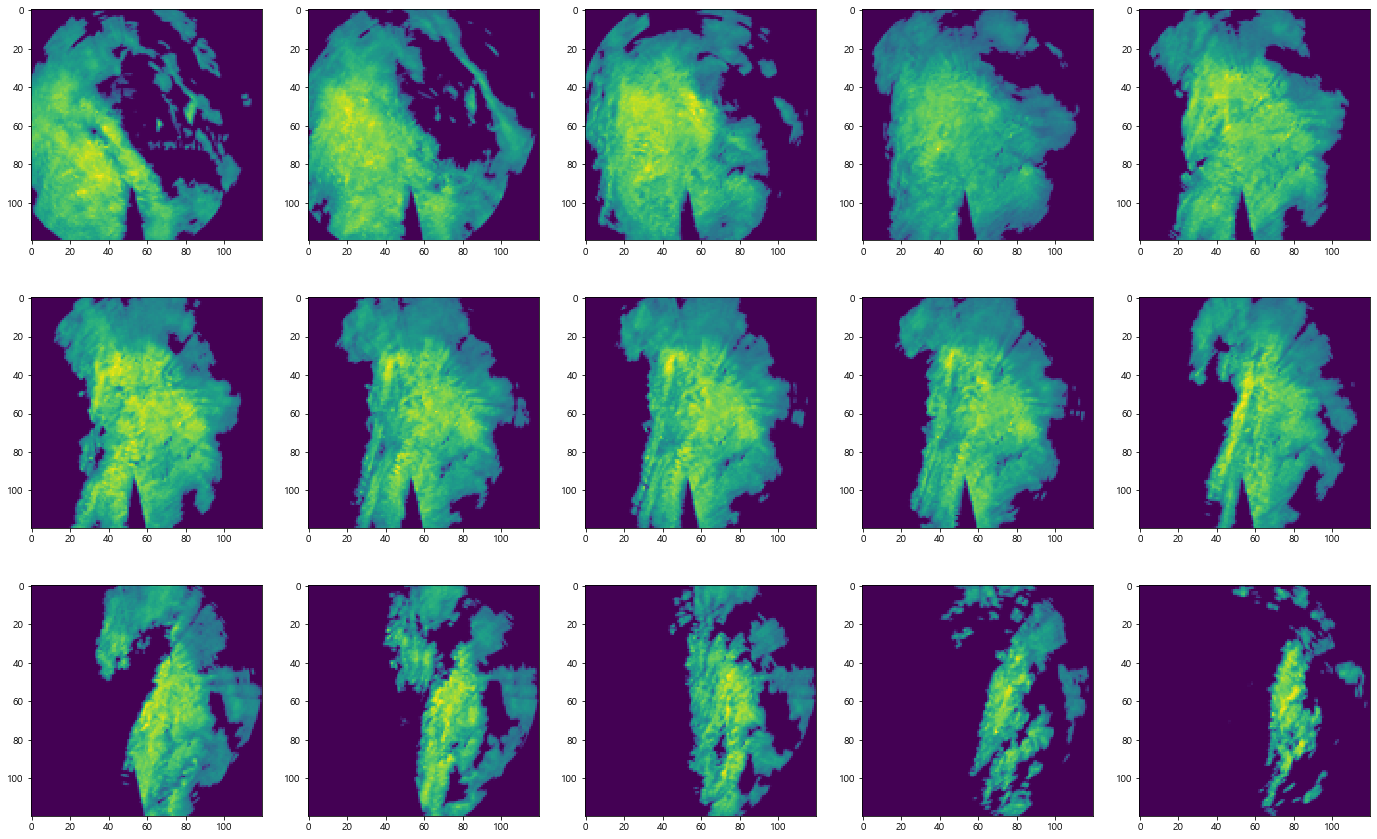

In [32]:
fig, axes = plt.subplots( 3,5 , figsize=(24, 5 *3))

counter = 0 
for row_ind in range(3):
    for col_ind in range(5):
        axes[row_ind][col_ind].imshow(   targets[counter, :, : , :].detach().cpu().numpy().reshape(120,120) )
        counter += 1

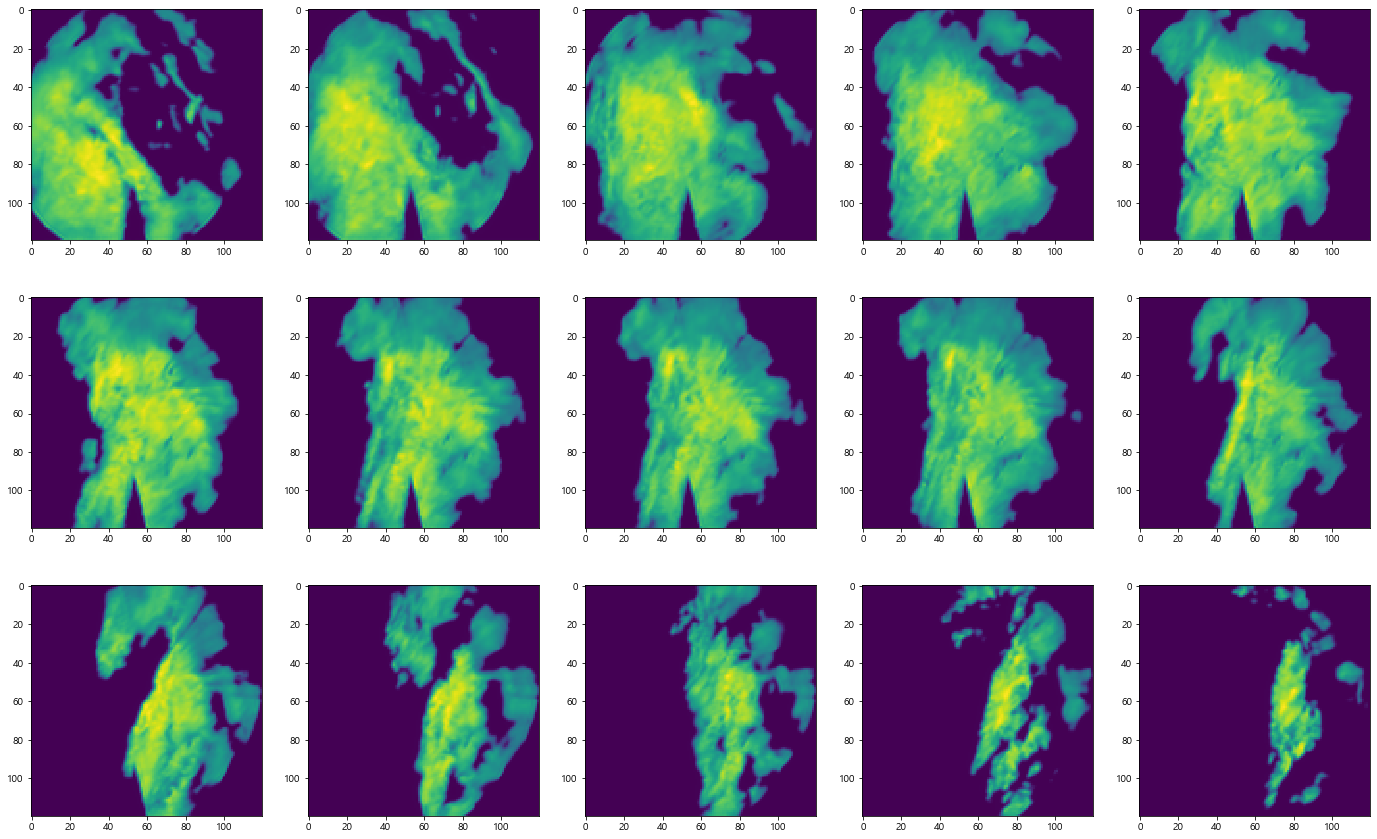

In [33]:
fig, axes = plt.subplots( 3,5 , figsize=(24, 5 *3))

counter = 0 
for row_ind in range(3):
    for col_ind in range(5):
        axes[row_ind][col_ind].imshow(   logits[counter, :, : , :].detach().cpu().numpy().reshape(120,120) )
        counter += 1